In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import numpy as np
import joblib


#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
train_dir = "./Data/Alzheimer_s Dataset/train"
test_dir = "./Data/Alzheimer_s Dataset/test"

In [7]:
# Set the input shape
input_shape = (128, 128, 3)
batch_size = 32

In [8]:
# Use ImageDataGenerator for data augmentation
data_generator = ImageDataGenerator(rescale=1./255)

In [9]:
# Load the training images
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 5121 images belonging to 4 classes.


In [10]:
# Load the test images
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1279 images belonging to 4 classes.


In [11]:
# Define the model architecture up to the feature extraction layer
model = Sequential([
    Conv2D(32, (3, 3), input_shape=input_shape),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64),
    Activation('relu'),
    Dropout(0.5)
])

In [12]:
# Extract features from training images 
train_features = model.predict(train_generator)
train_features = train_features.reshape(train_features.shape[0], -1)  # Flatten features
train_labels = train_generator.classes

  1/161 ━━━━━━━━━━━━━━━━━━━━ 1:54 718ms/step

161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step


In [13]:
# Extract features from test images 
test_features = model.predict(test_generator)
test_features = test_features.reshape(test_features.shape[0], -1)
test_labels = test_generator.classes

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step


In [14]:
# Use LightGBM 
lgb_classifier = lgb.LGBMClassifier(
    boosting_type='gbdt',  # Use gradient boosting
    num_leaves=31,         # Maximum leaves in one tree
    max_depth=-1,          # No maximum depth
    learning_rate=0.1,     # Step size
    n_estimators=100,      # Number of trees
    objective='multiclass',    # multi classification
)
lgb_classifier.fit(train_features, train_labels)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8251
[LightGBM] [Info] Number of data points in the train set: 5121, number of used features: 44
[LightGBM] [Info] Start training from score -1.966029
[LightGBM] [Info] Start training from score -4.589861
[LightGBM] [Info] Start training from score -0.693342
[LightGBM] [Info] Start training from score -1.050017


LGBMClassifier(objective='multiclass')

In [15]:
# Make predictions on the test data
test_predictions = lgb_classifier.predict(test_features)

In [16]:
# Calculate accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 51.52%


In [17]:
# Save the Keras CNN model as an .h5 file
model.save('models/cnn_feature_extractor8.h5')

In [18]:
# Save the trained LightGBM model
joblib.dump(lgb_classifier, 'models/lgb_classifier.pkl')

['models/lgb_classifier.pkl']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


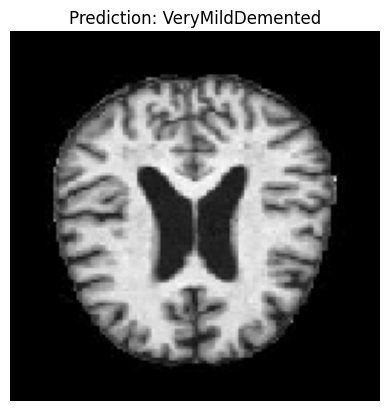

The image is classified as: VeryMildDemented


In [19]:
from keras.models import load_model
import joblib
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

cnn_model = load_model("models/cnn_feature_extractor8.h5")
dt_classifier = joblib.load("models/lgb_classifier.pkl")

def classify_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    features = cnn_model.predict(img_array)
    features = features.reshape(1, -1)

    prediction = dt_classifier.predict(features)
    
    class_labels = {0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}
    result = class_labels[prediction[0]]
    
    # Visualize the image and prediction
    plt.imshow(img)
    plt.title(f"Prediction: {result}")
    plt.axis('off')
    plt.show()

    return result

img_path = "./Data/Alzheimer_s Dataset/test\\VeryMildDemented\\26 (44).jpg"
result = classify_image(img_path)
print(f"The image is classified as: {result}")
